In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import logging
import numpy as np

import pandas as pd
pd.set_option('display.max_columns',None)
import numpy as np

import geopandas as gpd
from shapely import Point, LineString, Polygon, MultiPoint
from shapely.ops import nearest_points
from sklearn.cluster import DBSCAN

from tqdm import tqdm
tqdm.pandas()

# ÏãúÍ∞ÅÌôî ÎùºÏù¥Î∏åÎü¨Î¶¨
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager as fm, rc

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
font_path = '/usr/local/src/python3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/KoPub Dotum Medium.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

import yfinance as yf

In [14]:
# Ïï†Ìîå(Apple Inc.) Ï£ºÏãù Îç∞Ïù¥ÌÑ∞ Îã§Ïö¥Î°úÎìú (1ÎÖÑÏπò Îç∞Ïù¥ÌÑ∞)
data = yf.download('AAPL', start='2020-01-01', end='2023-01-01', interval='1d')

# Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏
data = data[['Close']]

[*********************100%***********************]  1 of 1 completed


In [15]:
data.dropna()

Price            Close
Ticker            AAPL
Date                  
2020-01-02   72.796028
2020-01-03   72.088295
2020-01-06   72.662720
2020-01-07   72.320961
2020-01-08   73.484352
...                ...
2022-12-23  130.487808
2022-12-27  128.676849
2022-12-28  124.728371
2022-12-29  128.261230
2022-12-30  128.577881

[756 rows x 1 columns]

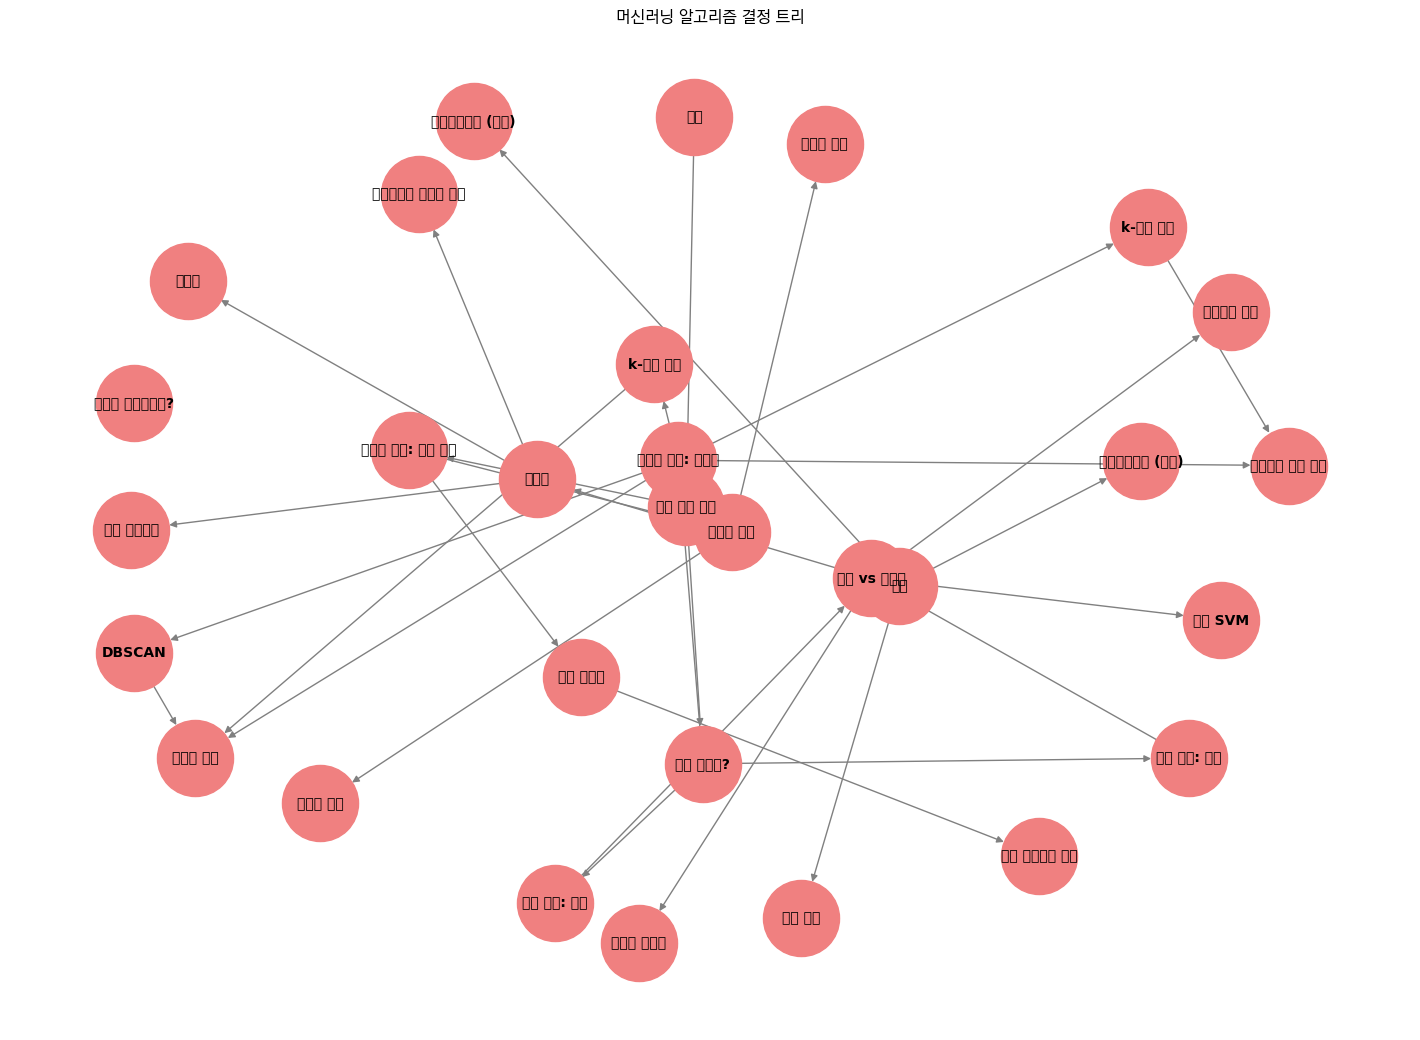

In [33]:
import networkx as nx
import matplotlib.pyplot as plt
# ÌïúÍ∏ÄÎ°ú Î≥ÄÌôòÎêú Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±
nodes_ko = {
    "START": "ÏãúÏûë",
    "Ï∞®Ïõê Ï∂ïÏÜå Ïó¨Î∂Ä": "Ï∞®Ïõê Ï∂ïÏÜå Ïó¨Î∂Ä",
    "ÎãµÏù¥ ÏûàÎäîÍ∞Ä?": "ÎãµÏù¥ ÏûàÎäîÍ∞Ä?",
    "Ïà´ÏûêÎ•º ÏòàÏ∏°ÌïòÎäîÍ∞Ä?": "Ïà´ÏûêÎ•º ÏòàÏ∏°ÌïòÎäîÍ∞Ä?",
    "ÎπÑÏßÄÎèÑ ÌïôÏäµ: Íµ∞ÏßëÌôî": "ÎπÑÏßÄÎèÑ ÌïôÏäµ: Íµ∞ÏßëÌôî",
    "ÎπÑÏßÄÎèÑ ÌïôÏäµ: Ï∞®Ïõê Ï∂ïÏÜå": "ÎπÑÏßÄÎèÑ ÌïôÏäµ: Ï∞®Ïõê Ï∂ïÏÜå",
    "ÏßÄÎèÑ ÌïôÏäµ: Î∂ÑÎ•ò": "ÏßÄÎèÑ ÌïôÏäµ: Î∂ÑÎ•ò",
    "ÏßÄÎèÑ ÌïôÏäµ: ÌöåÍ∑Ä": "ÏßÄÎèÑ ÌïôÏäµ: ÌöåÍ∑Ä",
    "Ï£ºÏ†ú Î™®Îç∏ÎßÅ": "Ï£ºÏ†ú Î™®Îç∏ÎßÅ",
    "ÌôïÎ•†Ï†Å Ï†ëÍ∑º": "ÌôïÎ•†Ï†Å Ï†ëÍ∑º",
    "Ïû†Ïû¨ ÎîîÎ¶¨ÌÅ¥Î†à Ìï†Îãπ": "Ïû†Ïû¨ ÎîîÎ¶¨ÌÅ¥Î†à Ìï†Îãπ",
    "Ï£ºÏÑ±Î∂Ñ Î∂ÑÏÑù": "Ï£ºÏÑ±Î∂Ñ Î∂ÑÏÑù",
    "ÌäπÏù¥Í∞í Î∂ÑÌï¥": "ÌäπÏù¥Í∞í Î∂ÑÌï¥",
    "ÏÜçÎèÑ vs Ï†ïÌôïÎèÑ": "ÏÜçÎèÑ vs Ï†ïÌôïÎèÑ",
    "ÏÜçÎèÑ": "ÏÜçÎèÑ",
    "Ï†ïÌôïÎèÑ": "Ï†ïÌôïÎèÑ",
    "ÏùòÏÇ¨Í≤∞Ï†ïÎÇòÎ¨¥ (Î∂ÑÎ•ò)": "ÏùòÏÇ¨Í≤∞Ï†ïÎÇòÎ¨¥ (Î∂ÑÎ•ò)",
    "Î°úÏßÄÏä§Ìã± ÌöåÍ∑Ä": "Î°úÏßÄÏä§Ìã± ÌöåÍ∑Ä",
    "ÎÇòÏù¥Î∏å Î≤†Ïù¥Ï¶à": "ÎÇòÏù¥Î∏å Î≤†Ïù¥Ï¶à",
    "Ïª§ÎÑê SVM": "Ïª§ÎÑê SVM",
    "ÎûúÎç§ Ìè¨Î†àÏä§Ìä∏": "ÎûúÎç§ Ìè¨Î†àÏä§Ìä∏",
    "Ïã†Í≤ΩÎßù": "Ïã†Í≤ΩÎßù",
    "Í∑∏ÎûòÎîîÏñ∏Ìä∏ Î∂ÄÏä§ÌåÖ Ìä∏Î¶¨": "Í∑∏ÎûòÎîîÏñ∏Ìä∏ Î∂ÄÏä§ÌåÖ Ìä∏Î¶¨",
    "ÏùòÏÇ¨Í≤∞Ï†ïÎÇòÎ¨¥ (ÌöåÍ∑Ä)": "ÏùòÏÇ¨Í≤∞Ï†ïÎÇòÎ¨¥ (ÌöåÍ∑Ä)",
    "ÏÑ†Ìòï ÌöåÍ∑Ä": "ÏÑ†Ìòï ÌöåÍ∑Ä",
    "Í∞ÄÏö∞ÏãúÏïà ÌòºÌï© Î™®Îç∏": "Í∞ÄÏö∞ÏãúÏïà ÌòºÌï© Î™®Îç∏",
    "k-ÌèâÍ∑† Íµ∞Ïßë": "k-ÌèâÍ∑† Íµ∞Ïßë",
    "k-Î™®Îìú Íµ∞Ïßë": "k-Î™®Îìú Íµ∞Ïßë",
    "Í≥ÑÏ∏µÏ†Å Íµ∞Ïßë": "Í≥ÑÏ∏µÏ†Å Íµ∞Ïßë",
    "DBSCAN": "DBSCAN"
}

# ÌïúÍ∏Ä ÎÖ∏Îìú Ï∂îÍ∞Ä
G_ko = nx.DiGraph()
G_ko.add_nodes_from(nodes_ko.values())

# ÌïúÍ∏Ä Ïó£ÏßÄ Ï∂îÍ∞Ä (ÎÖºÎ¶¨Ï†Å ÌùêÎ¶Ñ)
edges_ko = [
    ("ÏãúÏûë", "Ï∞®Ïõê Ï∂ïÏÜå Ïó¨Î∂Ä"),
    ("Ï∞®Ïõê Ï∂ïÏÜå Ïó¨Î∂Ä", "ÎπÑÏßÄÎèÑ ÌïôÏäµ: Ï∞®Ïõê Ï∂ïÏÜå"),
    ("Ï∞®Ïõê Ï∂ïÏÜå Ïó¨Î∂Ä", "ÎãµÏù¥ ÏûàÎäîÍ∞Ä?"),
    ("ÎπÑÏßÄÎèÑ ÌïôÏäµ: Ï∞®Ïõê Ï∂ïÏÜå", "Ï£ºÏ†ú Î™®Îç∏ÎßÅ"),
    ("ÎπÑÏßÄÎèÑ ÌïôÏäµ: Ï∞®Ïõê Ï∂ïÏÜå", "ÌôïÎ•†Ï†Å Ï†ëÍ∑º"),
    ("Ï£ºÏ†ú Î™®Îç∏ÎßÅ", "Ïû†Ïû¨ ÎîîÎ¶¨ÌÅ¥Î†à Ìï†Îãπ"),
    ("ÌôïÎ•†Ï†Å Ï†ëÍ∑º", "Ï£ºÏÑ±Î∂Ñ Î∂ÑÏÑù"),
    ("ÌôïÎ•†Ï†Å Ï†ëÍ∑º", "ÌäπÏù¥Í∞í Î∂ÑÌï¥"),
    ("ÎãµÏù¥ ÏûàÎäîÍ∞Ä?", "ÎπÑÏßÄÎèÑ ÌïôÏäµ: Íµ∞ÏßëÌôî"),
    ("ÎãµÏù¥ ÏûàÎäîÍ∞Ä?", "ÏßÄÎèÑ ÌïôÏäµ: Î∂ÑÎ•ò"),
    ("ÎãµÏù¥ ÏûàÎäîÍ∞Ä?", "ÏßÄÎèÑ ÌïôÏäµ: ÌöåÍ∑Ä"),
    ("ÏßÄÎèÑ ÌïôÏäµ: Î∂ÑÎ•ò", "ÏÜçÎèÑ vs Ï†ïÌôïÎèÑ"),
    ("ÏßÄÎèÑ ÌïôÏäµ: ÌöåÍ∑Ä", "ÏÜçÎèÑ vs Ï†ïÌôïÎèÑ"),
    ("ÏÜçÎèÑ vs Ï†ïÌôïÎèÑ", "ÏÜçÎèÑ"),
    ("ÏÜçÎèÑ vs Ï†ïÌôïÎèÑ", "Ï†ïÌôïÎèÑ"),
    ("ÏÜçÎèÑ", "ÏùòÏÇ¨Í≤∞Ï†ïÎÇòÎ¨¥ (Î∂ÑÎ•ò)"),
    ("ÏÜçÎèÑ", "ÏùòÏÇ¨Í≤∞Ï†ïÎÇòÎ¨¥ (ÌöåÍ∑Ä)"),
    ("ÏÜçÎèÑ", "ÏÑ†Ìòï ÌöåÍ∑Ä"),
    ("Ï†ïÌôïÎèÑ", "ÎûúÎç§ Ìè¨Î†àÏä§Ìä∏"),
    ("Ï†ïÌôïÎèÑ", "Ïã†Í≤ΩÎßù"),
    ("Ï†ïÌôïÎèÑ", "Í∑∏ÎûòÎîîÏñ∏Ìä∏ Î∂ÄÏä§ÌåÖ Ìä∏Î¶¨"),
    ("ÎπÑÏßÄÎèÑ ÌïôÏäµ: Íµ∞ÏßëÌôî", "k-ÌèâÍ∑† Íµ∞Ïßë"),
    ("ÎπÑÏßÄÎèÑ ÌïôÏäµ: Íµ∞ÏßëÌôî", "k-Î™®Îìú Íµ∞Ïßë"),
    ("ÎπÑÏßÄÎèÑ ÌïôÏäµ: Íµ∞ÏßëÌôî", "Í∞ÄÏö∞ÏãúÏïà ÌòºÌï© Î™®Îç∏"),
    ("ÎπÑÏßÄÎèÑ ÌïôÏäµ: Íµ∞ÏßëÌôî", "DBSCAN"),
    ("ÎπÑÏßÄÎèÑ ÌïôÏäµ: Íµ∞ÏßëÌôî", "Í≥ÑÏ∏µÏ†Å Íµ∞Ïßë"),
    ("k-ÌèâÍ∑† Íµ∞Ïßë", "Í∞ÄÏö∞ÏãúÏïà ÌòºÌï© Î™®Îç∏"),
    ("k-Î™®Îìú Íµ∞Ïßë", "Í≥ÑÏ∏µÏ†Å Íµ∞Ïßë"),
    ("DBSCAN", "Í≥ÑÏ∏µÏ†Å Íµ∞Ïßë"),
    ("ÏÜçÎèÑ vs Ï†ïÌôïÎèÑ", "Î°úÏßÄÏä§Ìã± ÌöåÍ∑Ä"),
    ("ÏÜçÎèÑ vs Ï†ïÌôïÎèÑ", "Ïª§ÎÑê SVM"),
    ("ÏÜçÎèÑ vs Ï†ïÌôïÎèÑ", "ÎÇòÏù¥Î∏å Î≤†Ïù¥Ï¶à")
]

# ÌïúÍ∏Ä Ïó£ÏßÄ Ï∂îÍ∞Ä
G_ko.add_edges_from(edges_ko)

# ÌïúÍ∏Ä Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
plt.figure(figsize=(14, 10))
pos_ko = nx.spring_layout(G_ko, seed=42, k=1)  # Î†àÏù¥ÏïÑÏõÉ ÏÑ§Ï†ï
nx.draw(G_ko, pos_ko, with_labels=True, node_color="lightcoral", edge_color="gray", node_size=3000, font_size=10, font_weight="bold", arrows=True)
plt.title("Î®∏Ïã†Îü¨Îãù ÏïåÍ≥†Î¶¨Ï¶ò Í≤∞Ï†ï Ìä∏Î¶¨")
plt.show()


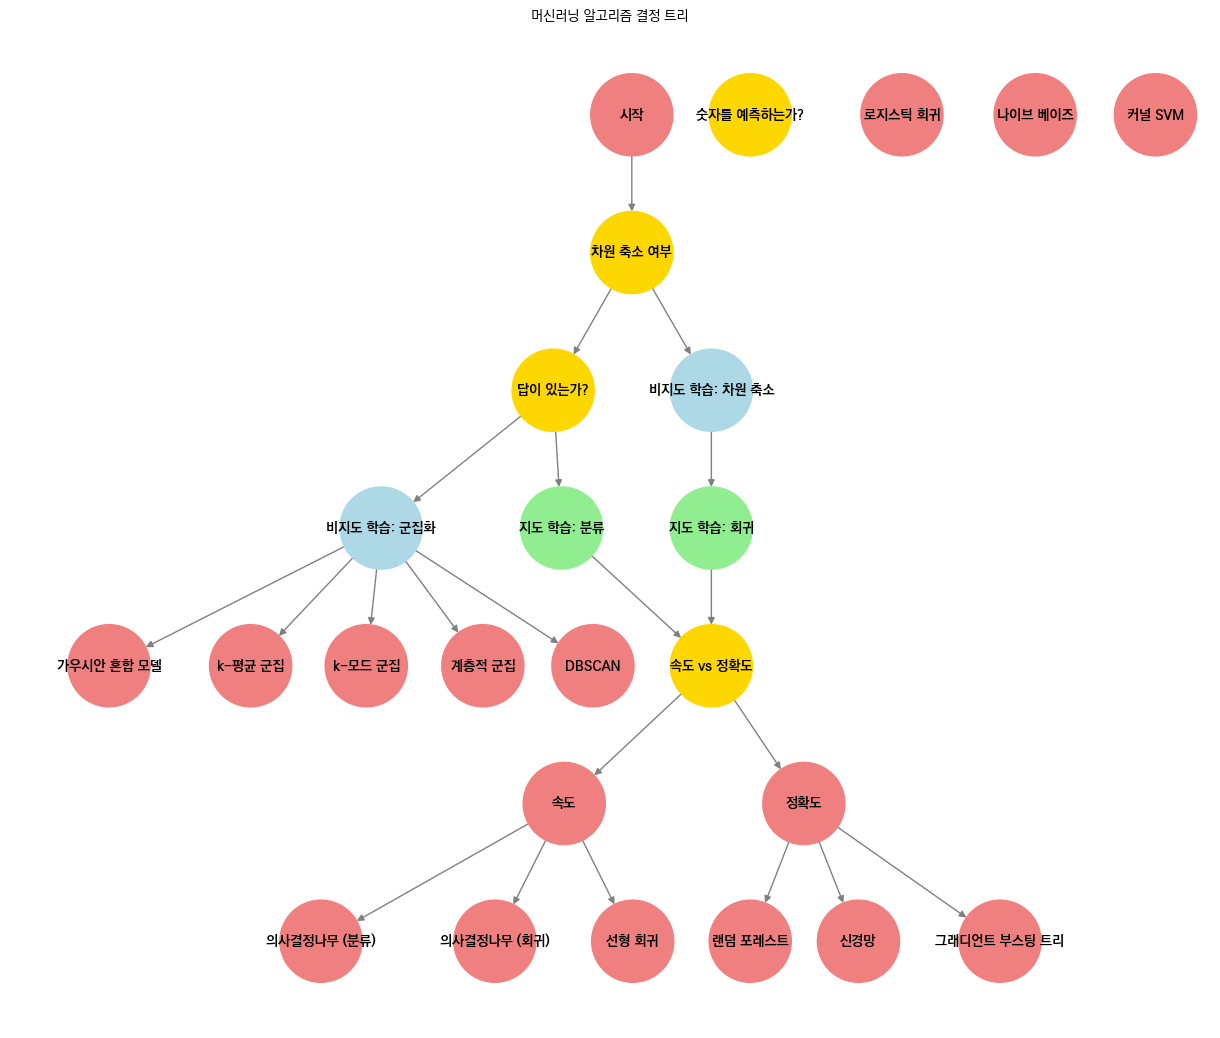

In [22]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# üîπ KoPub Dotum Ìè∞Ìä∏ Ï†ÅÏö© (ÏÑ§ÏπòÎêú Í≤ΩÎ°ú ÌôïÏù∏ ÌõÑ Î≥ÄÍ≤Ω ÌïÑÏöî)
font_path = "/usr/local/src/python3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/KoPub Dotum Medium.ttf"  # Ìè∞Ìä∏ Í≤ΩÎ°ú ÌôïÏù∏ ÌïÑÏöî
font_prop = fm.FontProperties(fname=font_path, size=10)

# ‚úÖ ÎÑ§Ìä∏ÏõåÌÅ¨ Í∑∏ÎûòÌîÑ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± (Î®∏Ïã†Îü¨Îãù ÏïåÍ≥†Î¶¨Ï¶ò Í≤∞Ï†ï Ìä∏Î¶¨)
G_ko = nx.DiGraph()

# ÎÖ∏Îìú Ï∂îÍ∞Ä (ÏùòÏÇ¨Í≤∞Ï†ï ÏßàÎ¨∏ Î∞è ÏïåÍ≥†Î¶¨Ï¶ò)
nodes = {
    "START": "ÏãúÏûë",
    "Ï∞®Ïõê Ï∂ïÏÜå Ïó¨Î∂Ä": "Ï∞®Ïõê Ï∂ïÏÜå Ïó¨Î∂Ä",
    "ÎãµÏù¥ ÏûàÎäîÍ∞Ä?": "ÎãµÏù¥ ÏûàÎäîÍ∞Ä?",
    "Ïà´ÏûêÎ•º ÏòàÏ∏°ÌïòÎäîÍ∞Ä?": "Ïà´ÏûêÎ•º ÏòàÏ∏°ÌïòÎäîÍ∞Ä?",
    "ÎπÑÏßÄÎèÑ ÌïôÏäµ: Íµ∞ÏßëÌôî": "ÎπÑÏßÄÎèÑ ÌïôÏäµ: Íµ∞ÏßëÌôî",
    "ÎπÑÏßÄÎèÑ ÌïôÏäµ: Ï∞®Ïõê Ï∂ïÏÜå": "ÎπÑÏßÄÎèÑ ÌïôÏäµ: Ï∞®Ïõê Ï∂ïÏÜå",
    "ÏßÄÎèÑ ÌïôÏäµ: Î∂ÑÎ•ò": "ÏßÄÎèÑ ÌïôÏäµ: Î∂ÑÎ•ò",
    "ÏßÄÎèÑ ÌïôÏäµ: ÌöåÍ∑Ä": "ÏßÄÎèÑ ÌïôÏäµ: ÌöåÍ∑Ä",
    "ÏÜçÎèÑ vs Ï†ïÌôïÎèÑ": "ÏÜçÎèÑ vs Ï†ïÌôïÎèÑ",
    "ÏÜçÎèÑ": "ÏÜçÎèÑ",
    "Ï†ïÌôïÎèÑ": "Ï†ïÌôïÎèÑ",
    "ÏùòÏÇ¨Í≤∞Ï†ïÎÇòÎ¨¥ (Î∂ÑÎ•ò)": "ÏùòÏÇ¨Í≤∞Ï†ïÎÇòÎ¨¥ (Î∂ÑÎ•ò)",
    "Î°úÏßÄÏä§Ìã± ÌöåÍ∑Ä": "Î°úÏßÄÏä§Ìã± ÌöåÍ∑Ä",
    "ÎÇòÏù¥Î∏å Î≤†Ïù¥Ï¶à": "ÎÇòÏù¥Î∏å Î≤†Ïù¥Ï¶à",
    "Ïª§ÎÑê SVM": "Ïª§ÎÑê SVM",
    "ÎûúÎç§ Ìè¨Î†àÏä§Ìä∏": "ÎûúÎç§ Ìè¨Î†àÏä§Ìä∏",
    "Ïã†Í≤ΩÎßù": "Ïã†Í≤ΩÎßù",
    "Í∑∏ÎûòÎîîÏñ∏Ìä∏ Î∂ÄÏä§ÌåÖ Ìä∏Î¶¨": "Í∑∏ÎûòÎîîÏñ∏Ìä∏ Î∂ÄÏä§ÌåÖ Ìä∏Î¶¨",
    "ÏùòÏÇ¨Í≤∞Ï†ïÎÇòÎ¨¥ (ÌöåÍ∑Ä)": "ÏùòÏÇ¨Í≤∞Ï†ïÎÇòÎ¨¥ (ÌöåÍ∑Ä)",
    "ÏÑ†Ìòï ÌöåÍ∑Ä": "ÏÑ†Ìòï ÌöåÍ∑Ä",
    "Í∞ÄÏö∞ÏãúÏïà ÌòºÌï© Î™®Îç∏": "Í∞ÄÏö∞ÏãúÏïà ÌòºÌï© Î™®Îç∏",
    "k-ÌèâÍ∑† Íµ∞Ïßë": "k-ÌèâÍ∑† Íµ∞Ïßë",
    "k-Î™®Îìú Íµ∞Ïßë": "k-Î™®Îìú Íµ∞Ïßë",
    "Í≥ÑÏ∏µÏ†Å Íµ∞Ïßë": "Í≥ÑÏ∏µÏ†Å Íµ∞Ïßë",
    "DBSCAN": "DBSCAN"
}

# üîπ ÎÖ∏Îìú Ï∂îÍ∞Ä
G_ko.add_nodes_from(nodes.values())

# üîπ ÎÖºÎ¶¨Ï†Å ÌùêÎ¶ÑÏùÑ ÎÇòÌÉÄÎÇ¥Îäî Ïó£ÏßÄ Ï∂îÍ∞Ä
edges = [
    ("ÏãúÏûë", "Ï∞®Ïõê Ï∂ïÏÜå Ïó¨Î∂Ä"),
    ("Ï∞®Ïõê Ï∂ïÏÜå Ïó¨Î∂Ä", "ÎπÑÏßÄÎèÑ ÌïôÏäµ: Ï∞®Ïõê Ï∂ïÏÜå"),
    ("Ï∞®Ïõê Ï∂ïÏÜå Ïó¨Î∂Ä", "ÎãµÏù¥ ÏûàÎäîÍ∞Ä?"),
    ("ÎπÑÏßÄÎèÑ ÌïôÏäµ: Ï∞®Ïõê Ï∂ïÏÜå", "ÏßÄÎèÑ ÌïôÏäµ: ÌöåÍ∑Ä"),
    ("ÎãµÏù¥ ÏûàÎäîÍ∞Ä?", "ÎπÑÏßÄÎèÑ ÌïôÏäµ: Íµ∞ÏßëÌôî"),
    ("ÎãµÏù¥ ÏûàÎäîÍ∞Ä?", "ÏßÄÎèÑ ÌïôÏäµ: Î∂ÑÎ•ò"),
    ("ÏßÄÎèÑ ÌïôÏäµ: Î∂ÑÎ•ò", "ÏÜçÎèÑ vs Ï†ïÌôïÎèÑ"),
    ("ÏßÄÎèÑ ÌïôÏäµ: ÌöåÍ∑Ä", "ÏÜçÎèÑ vs Ï†ïÌôïÎèÑ"),
    ("ÏÜçÎèÑ vs Ï†ïÌôïÎèÑ", "ÏÜçÎèÑ"),
    ("ÏÜçÎèÑ vs Ï†ïÌôïÎèÑ", "Ï†ïÌôïÎèÑ"),
    ("ÏÜçÎèÑ", "ÏùòÏÇ¨Í≤∞Ï†ïÎÇòÎ¨¥ (Î∂ÑÎ•ò)"),
    ("ÏÜçÎèÑ", "ÏùòÏÇ¨Í≤∞Ï†ïÎÇòÎ¨¥ (ÌöåÍ∑Ä)"),
    ("ÏÜçÎèÑ", "ÏÑ†Ìòï ÌöåÍ∑Ä"),
    ("Ï†ïÌôïÎèÑ", "ÎûúÎç§ Ìè¨Î†àÏä§Ìä∏"),
    ("Ï†ïÌôïÎèÑ", "Ïã†Í≤ΩÎßù"),
    ("Ï†ïÌôïÎèÑ", "Í∑∏ÎûòÎîîÏñ∏Ìä∏ Î∂ÄÏä§ÌåÖ Ìä∏Î¶¨"),
    ("ÎπÑÏßÄÎèÑ ÌïôÏäµ: Íµ∞ÏßëÌôî", "k-ÌèâÍ∑† Íµ∞Ïßë"),
    ("ÎπÑÏßÄÎèÑ ÌïôÏäµ: Íµ∞ÏßëÌôî", "k-Î™®Îìú Íµ∞Ïßë"),
    ("ÎπÑÏßÄÎèÑ ÌïôÏäµ: Íµ∞ÏßëÌôî", "Í∞ÄÏö∞ÏãúÏïà ÌòºÌï© Î™®Îç∏"),
    ("ÎπÑÏßÄÎèÑ ÌïôÏäµ: Íµ∞ÏßëÌôî", "DBSCAN"),
    ("ÎπÑÏßÄÎèÑ ÌïôÏäµ: Íµ∞ÏßëÌôî", "Í≥ÑÏ∏µÏ†Å Íµ∞Ïßë")
]

# üîπ Ïó£ÏßÄ Ï∂îÍ∞Ä
G_ko.add_edges_from(edges)

# ‚úÖ Í≥ÑÏ∏µÏ†ÅÏù∏ Î†àÏù¥ÏïÑÏõÉ Ï†ÅÏö© (Graphviz ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏÇ¨Ïö©)
pos_ko = nx.nx_agraph.graphviz_layout(G_ko, prog="dot")  # Ìä∏Î¶¨Ìòï Íµ¨Ï°∞

# üîπ ÏÉâÏÉÅ Íµ¨Î∂Ñ
question_nodes = {"Ï∞®Ïõê Ï∂ïÏÜå Ïó¨Î∂Ä", "ÎãµÏù¥ ÏûàÎäîÍ∞Ä?", "Ïà´ÏûêÎ•º ÏòàÏ∏°ÌïòÎäîÍ∞Ä?", "ÏÜçÎèÑ vs Ï†ïÌôïÎèÑ"}
unsupervised_nodes = {"ÎπÑÏßÄÎèÑ ÌïôÏäµ: Íµ∞ÏßëÌôî", "ÎπÑÏßÄÎèÑ ÌïôÏäµ: Ï∞®Ïõê Ï∂ïÏÜå"}
supervised_nodes = {"ÏßÄÎèÑ ÌïôÏäµ: Î∂ÑÎ•ò", "ÏßÄÎèÑ ÌïôÏäµ: ÌöåÍ∑Ä"}
algorithm_nodes = set(G_ko.nodes()) - (question_nodes | unsupervised_nodes | supervised_nodes)

node_colors = []
for node in G_ko.nodes():
    if node in question_nodes:
        node_colors.append("gold")  # Ï£ºÏöî ÏßàÎ¨∏ (ÎÖ∏ÎûÄÏÉâ)
    elif node in unsupervised_nodes:
        node_colors.append("lightblue")  # ÎπÑÏßÄÎèÑ ÌïôÏäµ (ÌååÎûÄÏÉâ)
    elif node in supervised_nodes:
        node_colors.append("lightgreen")  # ÏßÄÎèÑ ÌïôÏäµ (Ïó∞ÎëêÏÉâ)
    else:
        node_colors.append("lightcoral")  # ÏïåÍ≥†Î¶¨Ï¶ò (Îπ®Í∞ÑÏÉâ)

# üîπ Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞ (ÏûÖÏ≤¥ Ìö®Í≥º Ï∂îÍ∞Ä)
plt.figure(figsize=(12,10))
nx.draw(G_ko, pos_ko, with_labels=True, node_color=node_colors, edge_color="gray",
        node_size=3500, font_size=10, font_weight="bold", arrows=True,
        font_family=font_prop.get_name())  # ‚úÖ Ìè∞Ìä∏ Ï†ÅÏö©

# üîπ Ï†úÎ™© Ï∂îÍ∞Ä
plt.title("Î®∏Ïã†Îü¨Îãù ÏïåÍ≥†Î¶¨Ï¶ò Í≤∞Ï†ï Ìä∏Î¶¨", fontproperties=font_prop)
plt.show()


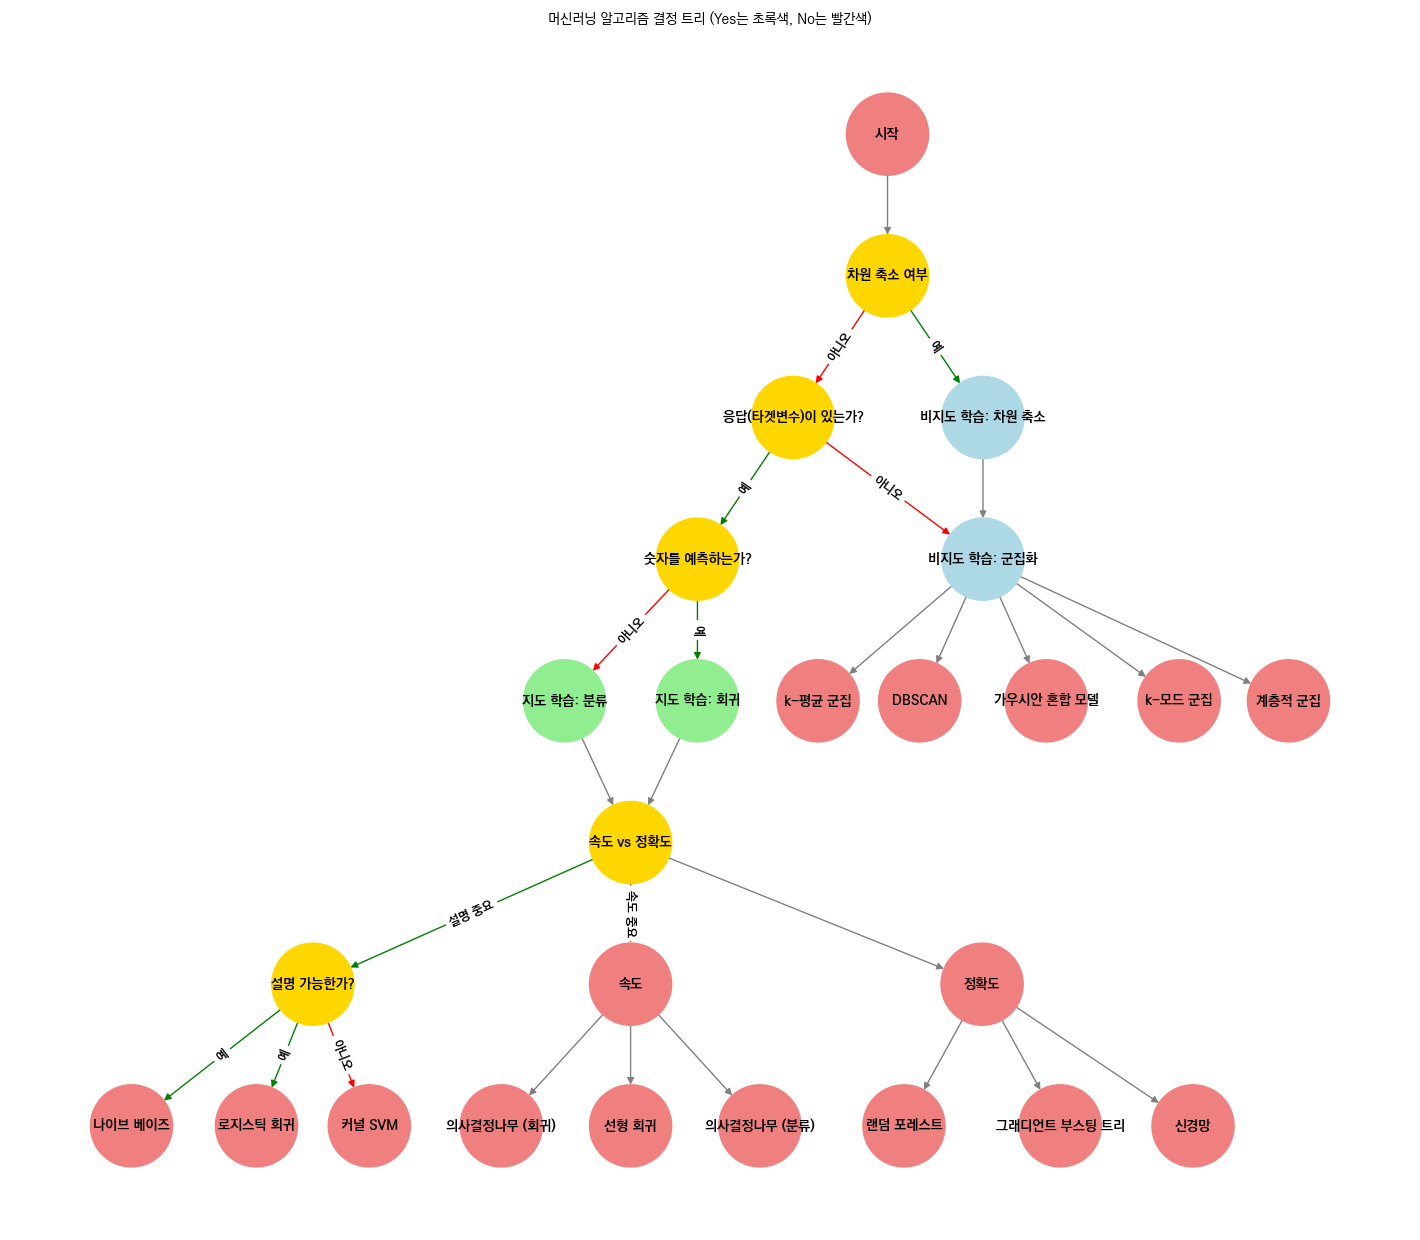

In [32]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# üîπ KoPub Dotum Ìè∞Ìä∏ Ï†ÅÏö© (ÏÑ§ÏπòÎêú Í≤ΩÎ°ú ÌôïÏù∏ ÌõÑ Î≥ÄÍ≤Ω ÌïÑÏöî)
font_path = "/usr/local/src/python3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/KoPub Dotum Medium.ttf"  # Ìè∞Ìä∏ Í≤ΩÎ°ú ÌôïÏù∏ ÌïÑÏöî
font_prop = fm.FontProperties(fname=font_path, size=10)

# ‚úÖ ÎÑ§Ìä∏ÏõåÌÅ¨ Í∑∏ÎûòÌîÑ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± (Î®∏Ïã†Îü¨Îãù ÏïåÍ≥†Î¶¨Ï¶ò Í≤∞Ï†ï Ìä∏Î¶¨)
G_ko = nx.DiGraph()

# üîπ Ïò¨Î∞îÎ•∏ ÎÖ∏Îìú Î™©Î°ù (ÌïúÍ∏Ä Î≥ÄÌôò Î∞è ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄÏôÄ ÎèôÏùºÌïòÍ≤å Íµ¨ÏÑ±)
nodes_corrected = {
    "ÏãúÏûë", "Ï∞®Ïõê Ï∂ïÏÜå Ïó¨Î∂Ä", "ÏùëÎãµ(ÌÉÄÍ≤üÎ≥ÄÏàò)Ïù¥ ÏûàÎäîÍ∞Ä?", "Ïà´ÏûêÎ•º ÏòàÏ∏°ÌïòÎäîÍ∞Ä?",
    "ÎπÑÏßÄÎèÑ ÌïôÏäµ: Íµ∞ÏßëÌôî", "ÎπÑÏßÄÎèÑ ÌïôÏäµ: Ï∞®Ïõê Ï∂ïÏÜå",
    "ÏßÄÎèÑ ÌïôÏäµ: Î∂ÑÎ•ò", "ÏßÄÎèÑ ÌïôÏäµ: ÌöåÍ∑Ä",
    "ÏÜçÎèÑ vs Ï†ïÌôïÎèÑ", "ÏÑ§Î™Ö Í∞ÄÎä•ÌïúÍ∞Ä?", "ÏÜçÎèÑ", "Ï†ïÌôïÎèÑ",
    "ÏùòÏÇ¨Í≤∞Ï†ïÎÇòÎ¨¥ (Î∂ÑÎ•ò)", "Î°úÏßÄÏä§Ìã± ÌöåÍ∑Ä", "ÎÇòÏù¥Î∏å Î≤†Ïù¥Ï¶à", "Ïª§ÎÑê SVM",
    "ÎûúÎç§ Ìè¨Î†àÏä§Ìä∏", "Ïã†Í≤ΩÎßù", "Í∑∏ÎûòÎîîÏñ∏Ìä∏ Î∂ÄÏä§ÌåÖ Ìä∏Î¶¨",
    "ÏùòÏÇ¨Í≤∞Ï†ïÎÇòÎ¨¥ (ÌöåÍ∑Ä)", "ÏÑ†Ìòï ÌöåÍ∑Ä", "Í∞ÄÏö∞ÏãúÏïà ÌòºÌï© Î™®Îç∏",
    "k-ÌèâÍ∑† Íµ∞Ïßë", "k-Î™®Îìú Íµ∞Ïßë", "Í≥ÑÏ∏µÏ†Å Íµ∞Ïßë", "DBSCAN"
}

# ÎÖ∏Îìú Ï∂îÍ∞Ä
G_ko.add_nodes_from(nodes_corrected)

# üîπ Ïò¨Î∞îÎ•∏ Ïó£ÏßÄ Î™©Î°ù (Yes/No ÌëúÏãú Ï∂îÍ∞Ä)
edges_corrected = {
    ("ÏãúÏûë", "Ï∞®Ïõê Ï∂ïÏÜå Ïó¨Î∂Ä"),

    # Ï∞®Ïõê Ï∂ïÏÜå Î∂ÑÍ∏∞
    ("Ï∞®Ïõê Ï∂ïÏÜå Ïó¨Î∂Ä", "ÎπÑÏßÄÎèÑ ÌïôÏäµ: Ï∞®Ïõê Ï∂ïÏÜå"),
    ("Ï∞®Ïõê Ï∂ïÏÜå Ïó¨Î∂Ä", "ÏùëÎãµ(ÌÉÄÍ≤üÎ≥ÄÏàò)Ïù¥ ÏûàÎäîÍ∞Ä?"),

    # ÎπÑÏßÄÎèÑ ÌïôÏäµ
    ("ÎπÑÏßÄÎèÑ ÌïôÏäµ: Ï∞®Ïõê Ï∂ïÏÜå", "ÎπÑÏßÄÎèÑ ÌïôÏäµ: Íµ∞ÏßëÌôî"),

    # ÏßÄÎèÑ ÌïôÏäµ Î∂ÑÍ∏∞
    ("ÏùëÎãµ(ÌÉÄÍ≤üÎ≥ÄÏàò)Ïù¥ ÏûàÎäîÍ∞Ä?", "ÎπÑÏßÄÎèÑ ÌïôÏäµ: Íµ∞ÏßëÌôî"),
    ("ÏùëÎãµ(ÌÉÄÍ≤üÎ≥ÄÏàò)Ïù¥ ÏûàÎäîÍ∞Ä?", "Ïà´ÏûêÎ•º ÏòàÏ∏°ÌïòÎäîÍ∞Ä?"),
    
    # ÌöåÍ∑Ä vs Î∂ÑÎ•ò
    ("Ïà´ÏûêÎ•º ÏòàÏ∏°ÌïòÎäîÍ∞Ä?", "ÏßÄÎèÑ ÌïôÏäµ: ÌöåÍ∑Ä"),
    ("Ïà´ÏûêÎ•º ÏòàÏ∏°ÌïòÎäîÍ∞Ä?", "ÏßÄÎèÑ ÌïôÏäµ: Î∂ÑÎ•ò"),
    
    # ÏßÄÎèÑ ÌïôÏäµ Î∂ÑÍ∏∞
    ("ÏßÄÎèÑ ÌïôÏäµ: Î∂ÑÎ•ò", "ÏÜçÎèÑ vs Ï†ïÌôïÎèÑ"),
    ("ÏßÄÎèÑ ÌïôÏäµ: ÌöåÍ∑Ä", "ÏÜçÎèÑ vs Ï†ïÌôïÎèÑ"),

    # ÏÜçÎèÑ vs Ï†ïÌôïÎèÑ Î∂ÑÍ∏∞
    ("ÏÜçÎèÑ vs Ï†ïÌôïÎèÑ", "ÏÑ§Î™Ö Í∞ÄÎä•ÌïúÍ∞Ä?"),
    ("ÏÑ§Î™Ö Í∞ÄÎä•ÌïúÍ∞Ä?", "Î°úÏßÄÏä§Ìã± ÌöåÍ∑Ä"),
    ("ÏÑ§Î™Ö Í∞ÄÎä•ÌïúÍ∞Ä?", "ÎÇòÏù¥Î∏å Î≤†Ïù¥Ï¶à"),
    ("ÏÑ§Î™Ö Í∞ÄÎä•ÌïúÍ∞Ä?", "Ïª§ÎÑê SVM"),

    # ÏÜçÎèÑ vs Ï†ïÌôïÎèÑ Î∂ÑÍ∏∞ Í≥ÑÏÜç
    ("ÏÜçÎèÑ vs Ï†ïÌôïÎèÑ", "ÏÜçÎèÑ"),
    ("ÏÜçÎèÑ vs Ï†ïÌôïÎèÑ", "Ï†ïÌôïÎèÑ"),
    ("ÏÜçÎèÑ", "ÏùòÏÇ¨Í≤∞Ï†ïÎÇòÎ¨¥ (Î∂ÑÎ•ò)"),
    ("ÏÜçÎèÑ", "ÏùòÏÇ¨Í≤∞Ï†ïÎÇòÎ¨¥ (ÌöåÍ∑Ä)"),
    ("ÏÜçÎèÑ", "ÏÑ†Ìòï ÌöåÍ∑Ä"),
    ("Ï†ïÌôïÎèÑ", "ÎûúÎç§ Ìè¨Î†àÏä§Ìä∏"),
    ("Ï†ïÌôïÎèÑ", "Ïã†Í≤ΩÎßù"),
    ("Ï†ïÌôïÎèÑ", "Í∑∏ÎûòÎîîÏñ∏Ìä∏ Î∂ÄÏä§ÌåÖ Ìä∏Î¶¨"),

    # ÎπÑÏßÄÎèÑ ÌïôÏäµ Íµ∞ÏßëÌôî ÏïåÍ≥†Î¶¨Ï¶ò
    ("ÎπÑÏßÄÎèÑ ÌïôÏäµ: Íµ∞ÏßëÌôî", "k-ÌèâÍ∑† Íµ∞Ïßë"),
    ("ÎπÑÏßÄÎèÑ ÌïôÏäµ: Íµ∞ÏßëÌôî", "k-Î™®Îìú Íµ∞Ïßë"),
    ("ÎπÑÏßÄÎèÑ ÌïôÏäµ: Íµ∞ÏßëÌôî", "Í∞ÄÏö∞ÏãúÏïà ÌòºÌï© Î™®Îç∏"),
    ("ÎπÑÏßÄÎèÑ ÌïôÏäµ: Íµ∞ÏßëÌôî", "DBSCAN"),
    ("ÎπÑÏßÄÎèÑ ÌïôÏäµ: Íµ∞ÏßëÌôî", "Í≥ÑÏ∏µÏ†Å Íµ∞Ïßë")
}

# Ïó£ÏßÄ Ï∂îÍ∞Ä
G_ko.add_edges_from(edges_corrected)

# ‚úÖ Í≥ÑÏ∏µÏ†ÅÏù∏ Î†àÏù¥ÏïÑÏõÉ Ï†ÅÏö© (Graphviz Ìä∏Î¶¨Ìòï Íµ¨Ï°∞)
pos_ko = nx.nx_agraph.graphviz_layout(G_ko, prog="dot")

# üîπ ÏÉâÏÉÅ Íµ¨Î∂Ñ
question_nodes = {"Ï∞®Ïõê Ï∂ïÏÜå Ïó¨Î∂Ä", "ÏùëÎãµ(ÌÉÄÍ≤üÎ≥ÄÏàò)Ïù¥ ÏûàÎäîÍ∞Ä?", "Ïà´ÏûêÎ•º ÏòàÏ∏°ÌïòÎäîÍ∞Ä?", "ÏÜçÎèÑ vs Ï†ïÌôïÎèÑ", "ÏÑ§Î™Ö Í∞ÄÎä•ÌïúÍ∞Ä?"}
unsupervised_nodes = {"ÎπÑÏßÄÎèÑ ÌïôÏäµ: Íµ∞ÏßëÌôî", "ÎπÑÏßÄÎèÑ ÌïôÏäµ: Ï∞®Ïõê Ï∂ïÏÜå"}
supervised_nodes = {"ÏßÄÎèÑ ÌïôÏäµ: Î∂ÑÎ•ò", "ÏßÄÎèÑ ÌïôÏäµ: ÌöåÍ∑Ä"}
algorithm_nodes = set(G_ko.nodes()) - (question_nodes | unsupervised_nodes | supervised_nodes)

node_colors = []
for node in G_ko.nodes():
    if node in question_nodes:
        node_colors.append("gold")  # Ï£ºÏöî ÏßàÎ¨∏ (ÎÖ∏ÎûÄÏÉâ)
    elif node in unsupervised_nodes:
        node_colors.append("lightblue")  # ÎπÑÏßÄÎèÑ ÌïôÏäµ (ÌååÎûÄÏÉâ)
    elif node in supervised_nodes:
        node_colors.append("lightgreen")  # ÏßÄÎèÑ ÌïôÏäµ (Ïó∞ÎëêÏÉâ)
    else:
        node_colors.append("lightcoral")  # ÏïåÍ≥†Î¶¨Ï¶ò (Îπ®Í∞ÑÏÉâ)

# üîπ Yes / No ÎùºÎ≤® Ï∂îÍ∞Ä
edge_labels = {
    ("Ï∞®Ïõê Ï∂ïÏÜå Ïó¨Î∂Ä", "ÎπÑÏßÄÎèÑ ÌïôÏäµ: Ï∞®Ïõê Ï∂ïÏÜå"): "Ïòà",
    ("Ï∞®Ïõê Ï∂ïÏÜå Ïó¨Î∂Ä", "ÏùëÎãµ(ÌÉÄÍ≤üÎ≥ÄÏàò)Ïù¥ ÏûàÎäîÍ∞Ä?"): "ÏïÑÎãàÏò§",
    ("ÏùëÎãµ(ÌÉÄÍ≤üÎ≥ÄÏàò)Ïù¥ ÏûàÎäîÍ∞Ä?", "ÎπÑÏßÄÎèÑ ÌïôÏäµ: Íµ∞ÏßëÌôî"): "ÏïÑÎãàÏò§",
    ("ÏùëÎãµ(ÌÉÄÍ≤üÎ≥ÄÏàò)Ïù¥ ÏûàÎäîÍ∞Ä?", "Ïà´ÏûêÎ•º ÏòàÏ∏°ÌïòÎäîÍ∞Ä?"): "Ïòà",
    ("Ïà´ÏûêÎ•º ÏòàÏ∏°ÌïòÎäîÍ∞Ä?", "ÏßÄÎèÑ ÌïôÏäµ: ÌöåÍ∑Ä"): "Ïòà",
    ("Ïà´ÏûêÎ•º ÏòàÏ∏°ÌïòÎäîÍ∞Ä?", "ÏßÄÎèÑ ÌïôÏäµ: Î∂ÑÎ•ò"): "ÏïÑÎãàÏò§",
    ("ÏÜçÎèÑ vs Ï†ïÌôïÎèÑ", "ÏÑ§Î™Ö Í∞ÄÎä•ÌïúÍ∞Ä?"): "ÏÑ§Î™Ö Ï§ëÏöî",
    ("ÏÜçÎèÑ vs Ï†ïÌôïÎèÑ", "ÏÜçÎèÑ"): "ÏÜçÎèÑ Ï§ëÏöî",
    ("ÏÑ§Î™Ö Í∞ÄÎä•ÌïúÍ∞Ä?", "Î°úÏßÄÏä§Ìã± ÌöåÍ∑Ä"): "Ïòà",
    ("ÏÑ§Î™Ö Í∞ÄÎä•ÌïúÍ∞Ä?", "ÎÇòÏù¥Î∏å Î≤†Ïù¥Ï¶à"): "Ïòà",
    ("ÏÑ§Î™Ö Í∞ÄÎä•ÌïúÍ∞Ä?", "Ïª§ÎÑê SVM"): "ÏïÑÎãàÏò§",
}

# ‚úÖ Yes/No Ïó£ÏßÄ ÏÉâÏÉÅ ÏßÄÏ†ï
edge_colors = []
for u, v in G_ko.edges():
    if (u, v) in edge_labels:
        if edge_labels[(u, v)] in ["Ïòà", "ÏÑ§Î™Ö Ï§ëÏöî"]:
            edge_colors.append("green")  # ‚úÖ Yes (Ï¥àÎ°ùÏÉâ)
        elif edge_labels[(u, v)] in ["ÏïÑÎãàÏò§", "ÏÜçÎèÑ Ï§ëÏöî"]:
            edge_colors.append("red")  # ‚úÖ No (Îπ®Í∞ÑÏÉâ)
        else:
            edge_colors.append("gray")  # Í∏∞ÌÉÄ Ïó∞Í≤∞
    else:
        edge_colors.append("gray")  # Í∏∞Î≥∏ ÌöåÏÉâ

# ‚úÖ Í∑∏ÎûòÌîÑ Îã§Ïãú Í∑∏Î¶¨Í∏∞ (Yes/No ÏÑ† ÏÉâÏÉÅ Ï†ÅÏö©)
plt.figure(figsize=(14, 12))
nx.draw(G_ko, pos_ko, with_labels=True, node_color=node_colors, edge_color=edge_colors,
        node_size=3500, font_size=10, font_weight="bold", arrows=True,
        font_family=font_prop.get_name())  # ‚úÖ Ìè∞Ìä∏ Ï†ÅÏö©

# ‚úÖ Yes/No ÎùºÎ≤® Ï∂îÍ∞Ä (Ìè∞Ìä∏ Î¨∏Ï†ú Ìï¥Í≤∞)
nx.draw_networkx_edge_labels(G_ko, pos_ko, edge_labels=edge_labels,
                             font_size=9, font_color="black", font_weight="bold", 
                             font_family=font_prop.get_name())  # ‚úÖ Ìè∞Ìä∏ Ï†ÅÏö© Î∞©Ïãù Î≥ÄÍ≤Ω


# ‚úÖ Ï†úÎ™© Ï∂îÍ∞Ä
plt.title("Î®∏Ïã†Îü¨Îãù ÏïåÍ≥†Î¶¨Ï¶ò Í≤∞Ï†ï Ìä∏Î¶¨ (YesÎäî Ï¥àÎ°ùÏÉâ, NoÎäî Îπ®Í∞ÑÏÉâ)", fontproperties=font_prop)
plt.show()
